In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
print(df.shape)
print(df.columns)

(3020, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [4]:
# Cleaning up the data
df.isnull().values.any()
df = df.dropna()
df.shape

(3019, 7)

In [5]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


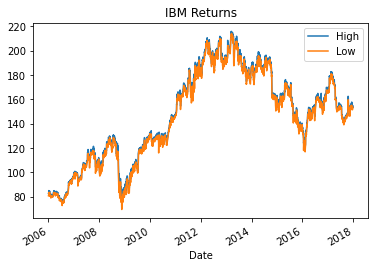

In [6]:
dr = df[['High', 'Low']]
dr.plot()
plt.title('IBM Returns');

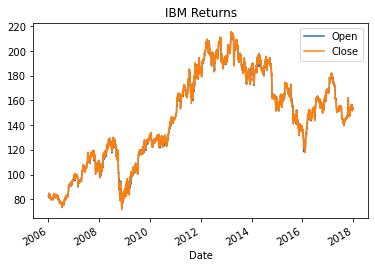

In [7]:
dr = df[['Open', 'Close']]
dr.plot()
plt.title('IBM Returns');

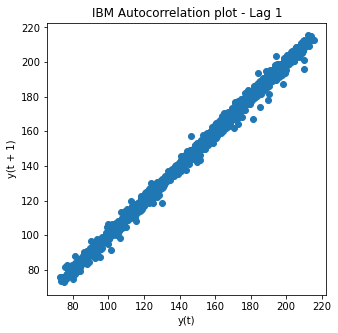

In [8]:
    from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 1');
# END_CODE_HERE

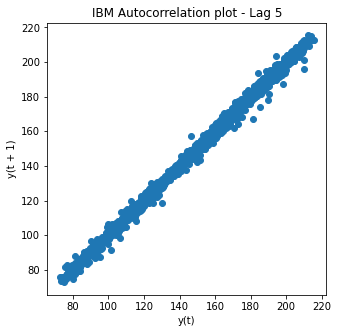

In [9]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 5');
# END_CODE_HERE

In [10]:
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]

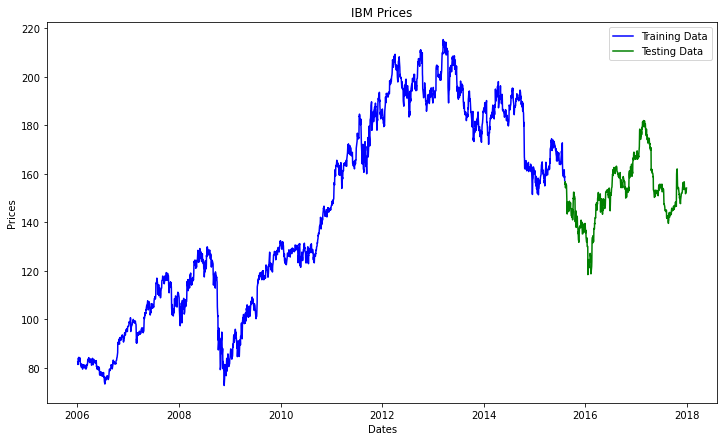

In [11]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

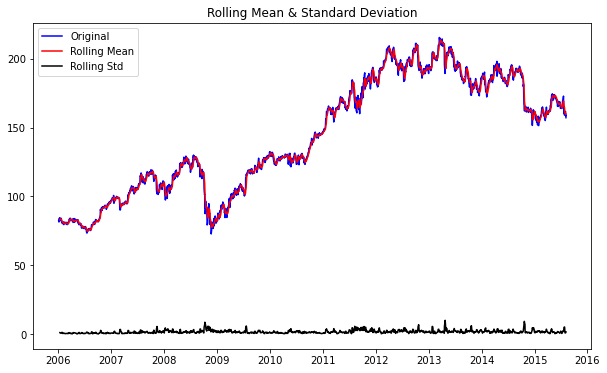

In [12]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [13]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

In [15]:

train_diff =train_series.diff(periods=1)
train_diff = train_diff.dropna(inplace = False)

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
result = adfuller(train_diff)

In [18]:
print('ADF Statistic: %f' % result[0])

ADF Statistic: -20.324277


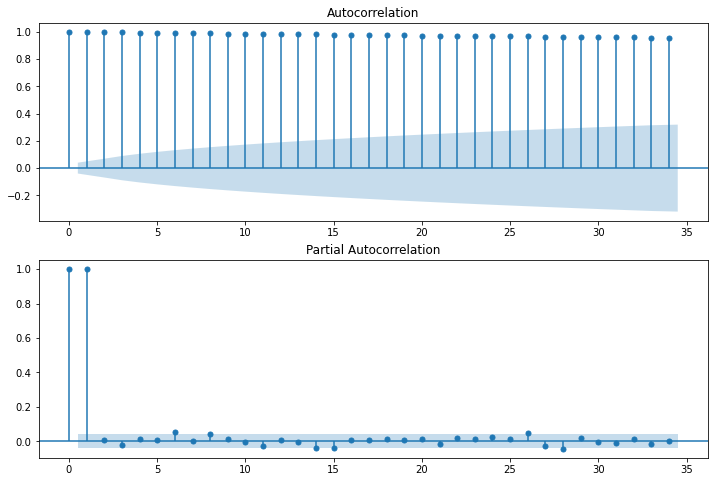

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

In [20]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

In [21]:
test_series = test_data['Open']
test_diff = test_series.diff(periods=1)
test_diff = test_diff.dropna(inplace = False)

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [24]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    model = model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit =model.fit()  # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=-0.5244367458993544, Expected=0.8800000000000239
Test Series Point: 100	Predicted=0.5055864873034758, Expected=-0.5100000000000193
Test Series Point: 200	Predicted=0.03541808264070445, Expected=2.0500000000000114
Test Series Point: 300	Predicted=-0.37919110896429586, Expected=-0.020000000000010232
Test Series Point: 400	Predicted=-0.7068807189290927, Expected=-0.36000000000001364
Test Series Point: 500	Predicted=-0.2969381359323155, Expected=0.5699999999999932
Test Series Point: 600	Predicted=-0.22481528553935248, Expected=0.4399999999999977
Wall time: 8min 35s


In [25]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((604,), (604,))

In [26]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 18.258
Symmetric Mean absolute percentage error: 2.445


In [27]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

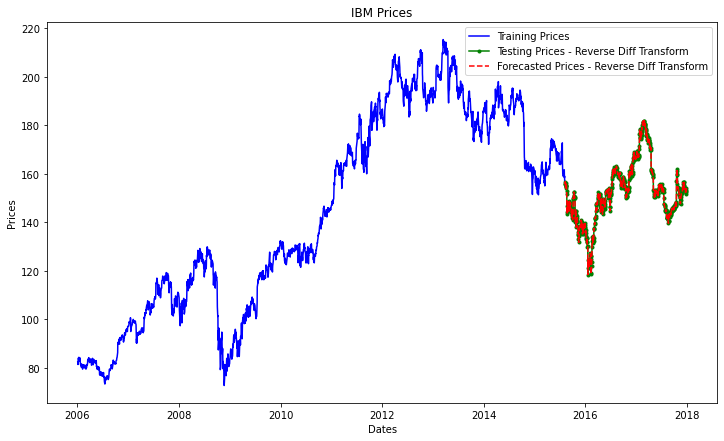

In [28]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

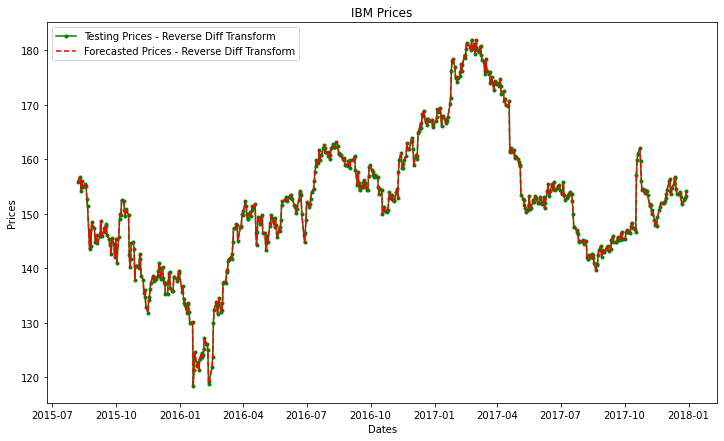

In [30]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

In [32]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [34]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [35]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2415,), (604,))

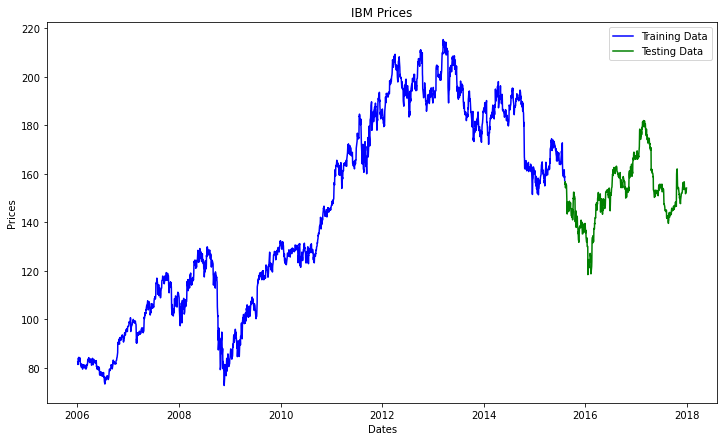

In [36]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

In [37]:
sc = MinMaxScaler(feature_range=(0,1))

In [54]:
train_series

Date
2006-01-03     82.45
2006-01-04     82.20
2006-01-05     81.40
2006-01-06     83.95
2006-01-09     84.10
               ...  
2015-07-31    161.40
2015-08-03    161.70
2015-08-04    158.40
2015-08-05    159.10
2015-08-06    157.13
Name: Open, Length: 2415, dtype: float64

In [57]:
train_series_df = train_series.to_frame()
training_set_scaled = sc.fit_transform(train_series_df)

In [58]:
training_set_scaled

array([[0.06807347],
       [0.06632081],
       [0.06071228],
       ...,
       [0.60053281],
       [0.60544027],
       [0.59162928]])

In [59]:
training_set_scaled.shape

(2415, 1)

In [60]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2355, 60), (2355,))

In [61]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [62]:
X_train.shape

(2355, 60, 1)

In [67]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

In [68]:
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(LSTM(units=64))

In [72]:
regressor.add(Dense(1, activation='softmax'))

In [73]:
regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(regressor.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 84,265
Trainable params: 84,265
Non-trainable params: 0
__________________________________________________

In [74]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
34/34 [==============================] - 9s 114ms/step - loss: 0.7341 - accuracy: 4.7192e-04 - val_loss: 0.7310 - val_accuracy: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 3s 75ms/step - loss: 0.7001 - accuracy: 4.7192e-04 - val_loss: 0.7239 - val_accuracy: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 3s 75ms/step - loss: 0.6977 - accuracy: 4.7192e-04 - val_loss: 0.7195 - val_accuracy: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 3s 74ms/step - loss: 0.6973 - accuracy: 4.7192e-04 - val_loss: 0.7167 - val_accuracy: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 3s 92ms/step - loss: 0.6969 - accuracy: 4.7192e-04 - val_loss: 0.7145 - val_accuracy: 0.0000e+00
Epoch 6/15
34/34 [==============================] - 3s 96ms/step - loss: 0.6965 - accuracy: 4.7192e-04 - val_loss: 0.7127 - val_accuracy: 0.0000e+00
Epoch 7/15
34/34 [==============================] - 3s 95ms/step - loss: 0.6962 - accuracy: 4.7192e-04 - 

In [76]:
train_last60 = train_series.tail(60)
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [78]:
test_series.shape
type(test_series)

pandas.core.series.Series

In [79]:
new_test_series = pd.concat([train_last60, test_series])
print(new_test_series.shape)
assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(664,)


In [80]:
test_series_df = test_series.to_frame()
test_set_scaled =  sc.fit_transform(test_series_df)

In [83]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(544, 60, 1)